In [4]:
prefix = '/home/ines/repositories/'
# prefix = '/Users/ineslaranjeira/Documents/Repositories/'

In [5]:
import numpy as np
# from aniposelib.boards import CharucoBoard, Checkerboard
from aniposelib.cameras import Camera, CameraGroup
from aniposelib.utils import load_pose2d_fnames
import cv2

In [7]:

""" 
IMPORTS
"""
import os
import numpy as np
import pickle
import pandas as pd
from one.api import ONE
from sklearn.manifold import TSNE
from matplotlib import pyplot as plt
from scipy import stats
from brainbox.io.one import SessionLoader
import scipy.interpolate as interpolate


# Get my functions
functions_path =  prefix + 'representation_learning_variability/Models/Sub-trial//2_fit_models/'
os.chdir(functions_path)
from preprocessing_functions import idxs_from_files
functions_path =  prefix + 'representation_learning_variability/Functions/'
os.chdir(functions_path)
from data_processing import save_and_log

one = ONE(mode='remote')

In [15]:
# LOAD DATA
bin_size = 0.017

num_train_batches = 5

data_path =prefix + 'representation_learning_variability/DATA/Sub-trial/Design matrix/' + 'v6_21Jul2025/' + str(bin_size) + '/'
all_files = os.listdir(data_path)
design_matrices = [item for item in all_files if 'design_matrix' in item and 'standardized' not in item]
idxs, mouse_names = idxs_from_files(design_matrices, bin_size)

# Subsample and embedd 

In [16]:
# Identify sessions availableto process
sessions_to_process = []
for m, mat in enumerate(idxs):
    mouse_name = mat[37:]
    session = mat[:36]
    sessions_to_process.append((mouse_name, session))

In [19]:
def resample_common_time(reference_time, timestamps, data, kind, fill_gaps=None):
    
    # # t = np.arange(t_init, t_end, 1 / freq)  # Evenly resample at frequency
    # if reference_time[-1] > timestamps[-1]:
    #     reference_time = reference_time[:-1]  # Occasionally due to precision errors the last sample may be outside of range.
    yinterp = interpolate.interp1d(timestamps, data, kind=kind, fill_value='extrapolate')(reference_time)
    
    if fill_gaps:
        #  Find large gaps and forward fill @fixme This is inefficient
        gaps, = np.where(np.diff(timestamps) >= fill_gaps)

        for i in gaps:
            yinterp[(reference_time >= timestamps[i]) & (reference_time < timestamps[i + 1])] = data[i]
            
    return yinterp, reference_time


def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx


# Code taken from 3D-Animal-Pose utilr.utilr_IO (see IBL_3d.py)
def refill_nan_array(pts_array_clean, info_dict, dimension):
    """we take our chopped array and embedd it in a full array with nans"""

    num_cameras = info_dict["num_cameras"]

    if dimension == "3d":
        pts_refill = np.empty(
            (info_dict["num_frames"] * info_dict["num_analyzed_body_parts"], 3)
        )
        pts_refill[:] = np.NaN
        pts_refill[info_dict["clean_point_indices"], :] = pts_array_clean

    else:

        pts_all_flat = np.arange(
            info_dict["num_frames"] * info_dict["num_analyzed_body_parts"]
        )
        indices_init = np.concatenate([pts_all_flat] * num_cameras)

        pts_refill = np.empty(
            (
                info_dict["num_frames"]
                * info_dict["num_analyzed_body_parts"]
                * info_dict["num_cameras"],
                2,
            )
        )

        pts_refill[:] = np.NaN
        pts_refill[
            np.isin(indices_init, info_dict["clean_point_indices"]), :
        ] = pts_array_clean

    return pts_refill


def ordered_arr_3d_to_dict(pts_array_3d, info_dict):
    """assuming you used np.flatten(). to create the 3d points.
    and assuming that the pts array is full size, including nans."""
    pose_dict = {}
    pose_dict["x_coords"] = pts_array_3d[:, 0].reshape(
        info_dict["num_frames"], info_dict["num_analyzed_body_parts"]
    )
    pose_dict["y_coords"] = pts_array_3d[:, 1].reshape(
        info_dict["num_frames"], info_dict["num_analyzed_body_parts"]
    )
    pose_dict["z_coords"] = pts_array_3d[:, 2].reshape(
        info_dict["num_frames"], info_dict["num_analyzed_body_parts"]
    )
    return pose_dict


def project(self, points):
    points = points.reshape(-1, 1, 3)
    out, _ = cv2.projectPoints(points, self.rvec, self.tvec,
                                self.matrix.astype('float64'),
                                self.dist.astype('float64'))
    return out

def reprojection_error(self, p3d, p2d):
    proj = self.project(p3d).reshape(p2d.shape)
    return p2d - proj


def set_ibl_cam_params():
    FOCAL_LENGTH_MM = 16
    SENSOR_SIZE = 12.7
    IMG_HEIGHT = 512
    IMG_WIDTH = 640

    # rightCamera (treat this as origin)
    params_r = np.zeros(8)
    params_r[0:3] = np.array([0, 0, 0])  # rotation
    params_r[3:6] = np.array([0, 0, 0])  # translation
    params_r[6] = FOCAL_LENGTH_MM * IMG_WIDTH / SENSOR_SIZE  # in pixels
    # params_r[7:] are distortion params, init to zero
    size_r = (IMG_WIDTH, IMG_HEIGHT)
    cam_r = Camera(size=size_r)
    cam_r.set_params(params_r)
    # update principal point
    cam_r_mat = cam_r.get_camera_matrix()
    cam_r_mat[0, 2] = IMG_WIDTH
    cam_r_mat[1, 2] = IMG_HEIGHT
    cam_r.set_camera_matrix(cam_r_mat)

    # leftCamera
    params_l = np.zeros(8)
    params_l[0:3] = np.array([0, 2.0127, 0])  # rotation; around y axis only, about 120 deg (2.0127 rad) from Guido's CAD
    params_l[3:6] = np.array([-1.5664, 0, 2.4738])  # translation; cameras are 292.8 mm apart
    # params_l[3:6] = np.array([-15.664, 0, 24.738])  # translation in cm; cameras are 292.8 mm apart

    params_l[6] = FOCAL_LENGTH_MM * 2 * IMG_WIDTH / SENSOR_SIZE
    # params_l[7:] are distortion params, init to zero
    size_l = (2 * IMG_WIDTH, 2 * IMG_HEIGHT)
    cam_l = Camera(size=size_l)
    cam_l.set_params(params_l)
    # update principal point
    cam_l_mat = cam_l.get_camera_matrix()
    cam_l_mat[0, 2] = 2 * IMG_WIDTH
    cam_l_mat[1, 2] = 2 * IMG_HEIGHT
    cam_l.set_camera_matrix(cam_l_mat)

    cam_group = CameraGroup(cameras=[cam_r, cam_l])

    return cam_group

In [40]:
session = sessions_to_process[10][1]

""" LOAD VARIABLES """
sl = SessionLoader(eid=session, one=one)
# sl.load_pose(views=['left', 'right'], tracker='lightningPose')
sl.load_pose(views=['left', 'right'])
poses = sl.pose

times_left = np.array(poses['leftCamera']['times'])
times_right = np.array(poses['rightCamera']['times'])

# get closest stamps or right cam (150 Hz) for each stamp of left (60 Hz)
idx_aligned = []
for t in times_left:
    idx_aligned.append(find_nearest(times_right, t))

# # paw_l in video left = paw_r in video right
# # Divide left coordinates by 2 to get them in half resolution like right cam; 
# # reduce temporal resolution of right cam to that of left cam
num_analyzed_body_parts = 2  # both paws 

cam_right_paw1 = np.array([poses['rightCamera']['paw_r_x'][idx_aligned], poses['rightCamera']['paw_r_y'][idx_aligned]]) 
cam_left_paw1 = np.array([poses['leftCamera']['paw_l_x']/2, poses['leftCamera']['paw_l_y']/2]) 

cam_right_paw2 = np.array([poses['rightCamera']['paw_l_x'][idx_aligned], poses['rightCamera']['paw_l_y'][idx_aligned]]) 
cam_left_paw2 = np.array([poses['leftCamera']['paw_r_x']/2, poses['leftCamera']['paw_r_y']/2]) 

# the format shall be such that points are concatenated, p1,p2,p3,p1,p2,p3, ... 
# num_analyzed_body_parts = 1
cam1 = np.zeros((len(idx_aligned) * num_analyzed_body_parts, 2)) 
cam1[0::num_analyzed_body_parts] = cam_right_paw1.T
cam1[1::num_analyzed_body_parts] = cam_right_paw2.T

cam2 = np.zeros((len(idx_aligned) * num_analyzed_body_parts, 2)) 
cam2[0::num_analyzed_body_parts] = cam_left_paw1.T
cam2[1::num_analyzed_body_parts] = cam_left_paw2.T

pts_array_2d_with_nans = np.array([cam1,cam2])

num_cameras, num_points_all, _ = pts_array_2d_with_nans.shape

# remove nans (any of the x_r,y_r, x_l, y_l) and keep clean_point_indices
non_nan_idc = ~np.isnan(pts_array_2d_with_nans).any(axis=2).any(axis=0)

info_dict = {}
info_dict['num_frames'] = len(times_left) 
info_dict['num_cameras'] = num_cameras
info_dict['num_analyzed_body_parts'] = num_analyzed_body_parts 
info_dict['num_points_all'] = num_points_all
info_dict['clean_point_indices'] = np.arange(num_points_all)[non_nan_idc]

pts_array_2d = pts_array_2d_with_nans[:,info_dict['clean_point_indices']]

In [121]:

# the format shall be such that points are concatenated, p1,p2,p3,p1,p2,p3, ... 
# num_analyzed_body_parts = 1
cam1 = np.zeros((len(idx_aligned) * num_analyzed_body_parts, 2)) 
cam1[0::num_analyzed_body_parts] = cam_right_paw1.T
cam1[1::num_analyzed_body_parts] = cam_right_paw2.T

cam2 = np.zeros((len(idx_aligned) * num_analyzed_body_parts, 2)) 
cam2[0::num_analyzed_body_parts] = cam_left_paw1.T
cam2[1::num_analyzed_body_parts] = cam_left_paw2.T

pts_array_2d_with_nans = np.array([cam1,cam2])

num_cameras, num_points_all, _ = pts_array_2d_with_nans.shape

# remove nans (any of the x_r,y_r, x_l, y_l) and keep clean_point_indices
non_nan_idc = ~np.isnan(pts_array_2d_with_nans).any(axis=2).any(axis=0)

info_dict = {}
info_dict['num_frames'] = len(times_left) 
info_dict['num_cameras'] = num_cameras
info_dict['num_analyzed_body_parts'] = num_analyzed_body_parts 
info_dict['num_points_all'] = num_points_all
info_dict['clean_point_indices'] = np.arange(num_points_all)[non_nan_idc]

pts_array_2d = pts_array_2d_with_nans[:,info_dict['clean_point_indices']]

In [22]:
path =  prefix + 'representation_learning_variability/Video and wheel/Behavioral variables/Paw/'
pts_array_2d = np.load(path+'pts_array_2d.npy')

In [43]:
np.shape(pts_array_2d)

(2, 524194, 2)

# Check data and initial error

In [123]:
np.shape(pts_array_2d)
# Cameras, 2 x datapoints, coordinates

(2, 524194, 2)

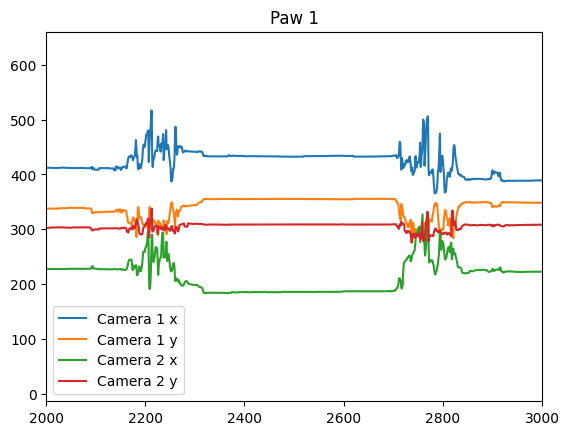

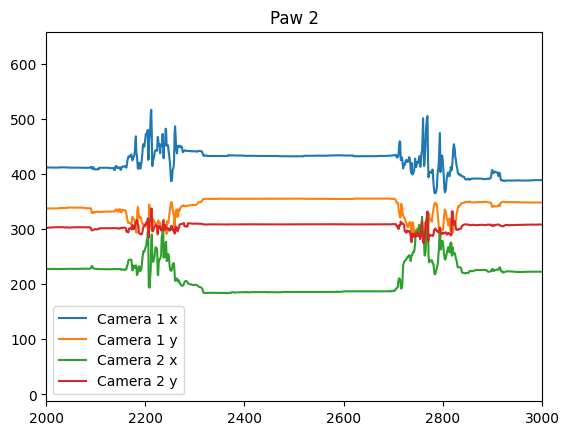

In [113]:
plt.plot(pts_array_2d[0, 0::2, 0], label='Camera 1 x')
plt.plot(pts_array_2d[0, 0::2, 1], label='Camera 1 y')
plt.plot(pts_array_2d[1, 0::2, 0], label='Camera 2 x')
plt.plot(pts_array_2d[1, 0::2, 1], label='Camera 2 y')
plt.xlim([2000, 3000])
plt.legend()
plt.title('Paw 1')
plt.show()

plt.plot(pts_array_2d[0, 1::2, 0], label='Camera 1 x')
plt.plot(pts_array_2d[0, 1::2, 1], label='Camera 1 y')
plt.plot(pts_array_2d[1, 1::2, 0], label='Camera 2 x')
plt.plot(pts_array_2d[1, 1::2, 1], label='Camera 2 y')
plt.xlim([2000, 3000])
plt.legend()
plt.title('Paw 2')
plt.show()

In [46]:
cam_group = set_ibl_cam_params()

In [27]:
p3ds = cam_group.triangulate(pts_array_2d, progress=True)
reprojected_2d = cam_group.project(p3ds).reshape(pts_array_2d.shape)
reprojerr_flat = cam_group.reprojection_error(p3ds, pts_array_2d, mean=True)

100%|███████████████████████| 480032/480032 [01:37<00:00, 4946.59it/s]


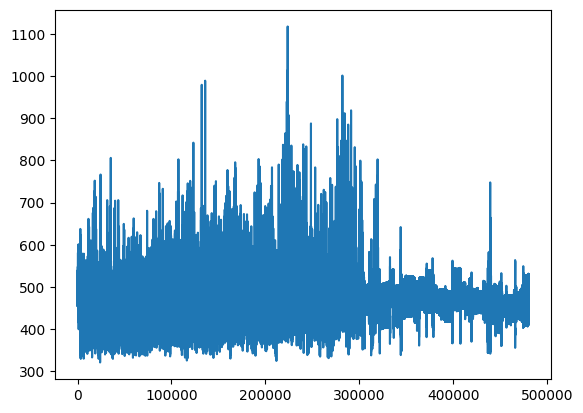

In [29]:
plt.plot(reprojerr_flat)

In [ ]:
initial_error = cam_group.average_error(pts_array_2d, median=False)

# Run bundle adjustment

In [47]:
cam_group = set_ibl_cam_params()

In [49]:
cam_group = set_ibl_cam_params()
error = cam_group.bundle_adjust_iter(pts_array_2d, n_iters=10, ftol=1e-8, max_nfev=500, verbose=False)
while error > 5:
    cam_group = set_ibl_cam_params()
    error = cam_group.bundle_adjust_iter(pts_array_2d, n_iters=10, ftol=1e-8, max_nfev=500, verbose=False)
    print(error)
print(error)

3.298714530468831


In [322]:
final_error = cam_group.average_error(pts_array_2d, median=False)
print(final_error)

14376.854479351014


# Triangulate

In [124]:
p3ds = cam_group.triangulate(pts_array_2d, progress=True)


100%|███████████████████████| 524194/524194 [02:01<00:00, 4326.23it/s]


## Reconstruct 2D data

In [125]:
reprojected_2d = cam_group.project(p3ds).reshape(pts_array_2d.shape)
reprojerr_flat = cam_group.reprojection_error(p3ds, pts_array_2d, mean=True)
np.shape(reprojected_2d)

(2, 524194, 2)

In [ ]:
# Code taken from 3D-Animal-Pose utilr.utilr_IO (see IBL_3d.py)
def refill_nan_array(pts_array_clean, info_dict, dimension):
    """we take our chopped array and embedd it in a full array with nans"""

    num_cameras = info_dict["num_cameras"]

    if dimension == "3d":
        pts_refill = np.empty(
            (info_dict["num_frames"] * info_dict["num_analyzed_body_parts"], 3)
        )
        pts_refill[:] = np.NaN
        pts_refill[info_dict["clean_point_indices"], :] = pts_array_clean

    else:
        # Ines changed to work with reprojected data format
        pts_all_flat = np.arange(
            info_dict["num_frames"] * info_dict["num_analyzed_body_parts"]
        )
        # indices_init = np.concatenate([pts_all_flat] * num_cameras)
        indices_init = pts_all_flat
        pts_refill = np.empty(
            (   info_dict["num_cameras"],
                info_dict["num_frames"]
                * info_dict["num_analyzed_body_parts"], 
                2,
            )
        ) * np.nan

        pts_refill[:,
            np.isin(indices_init, info_dict["clean_point_indices"]), :
        ] = pts_array_clean

    return pts_refill

In [224]:
p2d_nan = refill_nan_array(pts_array_2d, info_dict, '2d')

In [129]:
cam = refill_nan_array(reprojected_2d, info_dict, '2d')

In [293]:
all_keys_Left = pd.DataFrame(columns=['paw_l_x', 'paw_l_y', 'paw_r_x', 'paw_r_y', 
                                      'rec_paw_l_x', 'rec_paw_l_y', 'rec_paw_r_x', 'rec_paw_r_y', 'times'], index=range(len(times_right)))
all_keys_Left['times'] = times_right
all_keys_Left['paw_l_x'][idx_aligned] = poses['leftCamera']['paw_l_x']
all_keys_Left['paw_l_y'][idx_aligned] = poses['leftCamera']['paw_l_y']
all_keys_Left['paw_r_x'][idx_aligned] = poses['leftCamera']['paw_r_x']
all_keys_Left['paw_r_y'][idx_aligned] = poses['leftCamera']['paw_r_y']

all_keys_Left['rec_paw_l_x'][idx_aligned] = cam[1, 0::2, 0] * 2
all_keys_Left['rec_paw_l_y'][idx_aligned] = cam[1, 0::2, 1] * 2
all_keys_Left['rec_paw_r_x'][idx_aligned] = cam[1, 1::2, 0] * 2
all_keys_Left['rec_paw_r_y'][idx_aligned] = cam[1, 1::2, 1] * 2

all_keys_Right = pd.DataFrame(columns=['paw_l_x', 'paw_l_y', 'paw_r_x', 'paw_r_y', 
                                      'rec_paw_l_x', 'rec_paw_l_y', 'rec_paw_r_x', 'rec_paw_r_y', 'times'], index=range(len(times_right)))
all_keys_Right['times'] = times_right
all_keys_Right['paw_l_x'] = poses['rightCamera']['paw_l_x']
all_keys_Right['paw_l_y'] = poses['rightCamera']['paw_l_y']
all_keys_Right['paw_r_x'] = poses['rightCamera']['paw_r_x']
all_keys_Right['paw_r_y'] = poses['rightCamera']['paw_r_y']

all_keys_Right['rec_paw_l_x'][idx_aligned] = cam[0, 1::2, 0]
all_keys_Right['rec_paw_l_y'][idx_aligned] = cam[0, 1::2, 1]
all_keys_Right['rec_paw_r_x'][idx_aligned] = cam[0, 0::2, 0]
all_keys_Right['rec_paw_r_y'][idx_aligned] = cam[0, 0::2, 1]

all_keys_Left.to_parquet('leftCamera_keypoints')
all_keys_Right.to_parquet('rightCamera_keypoints')

/tmp/ipykernel_38901/3142739591.py:4: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  all_keys_Left['paw_l_x'][idx_aligned] = poses['leftCamera']['paw_l_x']
/tmp/ipykernel_38901/3142739591.py:4: SettingWithCopyWarning: 
A value is trying to be

/tmp/ipykernel_38901/2851983646.py:11: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


Text(0, 0.5, 'Pixels')

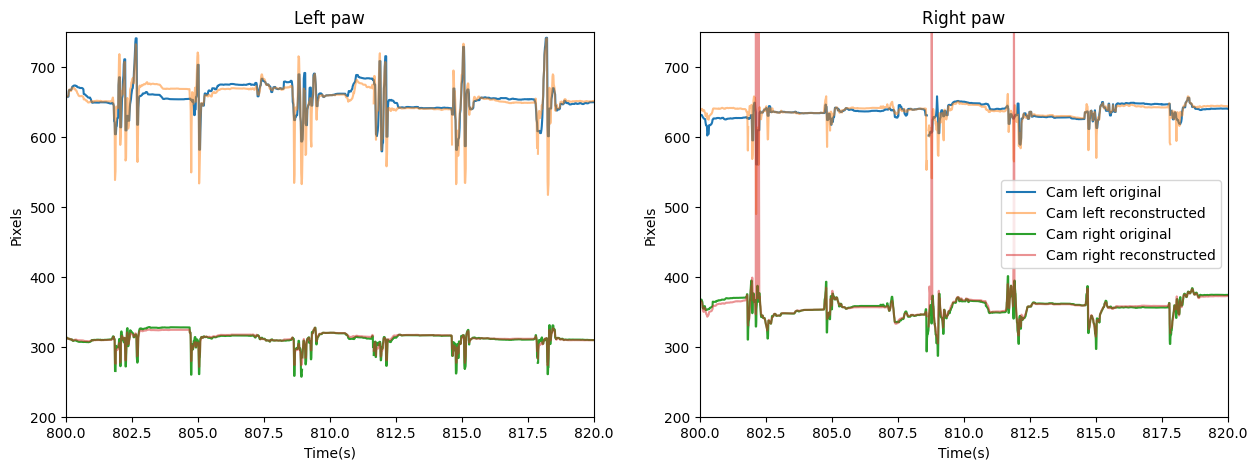

In [308]:
init = 800
fig, ax = plt.subplots(nrows=1, ncols=2, sharex=False, sharey=False, figsize=[15, 5])

ax[0].plot(all_keys_Left['times'][idx_aligned], all_keys_Left['paw_r_y'][idx_aligned], alpha=1, label='Cam left original')
ax[0].plot(all_keys_Left['times'][idx_aligned], all_keys_Left['rec_paw_r_y'][idx_aligned], alpha=.5, label='Cam left reconstructed')
ax[0].plot(all_keys_Right['times'], all_keys_Right['paw_l_y'], alpha=1, label='Cam right original')
ax[0].plot(all_keys_Right['times'][idx_aligned], all_keys_Right['rec_paw_l_y'][idx_aligned], alpha=.5, label='Cam right reconstructed')
ax[0].set_xlim([init, init+20])
ax[0].set_ylim([200, 750])
# plt.ylim(0, 700)
plt.legend()
ax[0].set_title('Left paw')
ax[0].set_xlabel('Time(s)')
ax[0].set_ylabel('Pixels')



ax[1].plot(all_keys_Left['times'][idx_aligned], all_keys_Left['paw_l_y'][idx_aligned], alpha=1, label='Cam left original')
ax[1].plot(all_keys_Left['times'][idx_aligned], all_keys_Left['rec_paw_l_y'][idx_aligned], alpha=.5, label='Cam left reconstructed')
# plt.xlim([init, init+10])
# plt.ylim([500, 700])
# ax[1].legend()
# plt.title('Camera right - right paw')
# plt.show()
ax[1].plot(all_keys_Right['times'], all_keys_Right['paw_r_y'], alpha=1, label='Cam right original')
ax[1].plot(all_keys_Right['times'][idx_aligned], all_keys_Right['rec_paw_r_y'][idx_aligned], alpha=.5, label='Cam right reconstructed')
ax[1].set_xlim([init, init+20])
ax[1].set_ylim([200, 750])
# plt.ylim(0, 700)

plt.legend()
plt.title('Right paw')
plt.xlabel('Time(s)')
plt.ylabel('Pixels')

(0.0, 100.0)

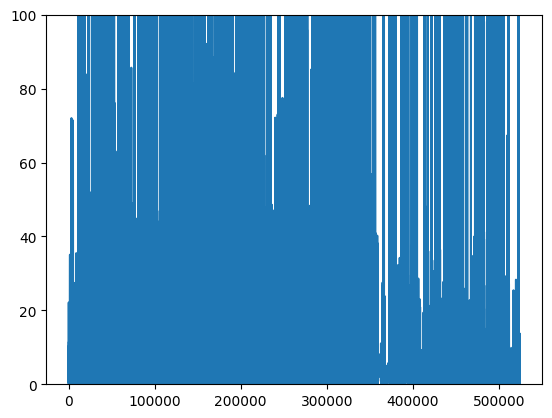

In [218]:
plt.plot(reprojerr_flat)
plt.ylim([0, 100])

(1600.0, 1800.0)

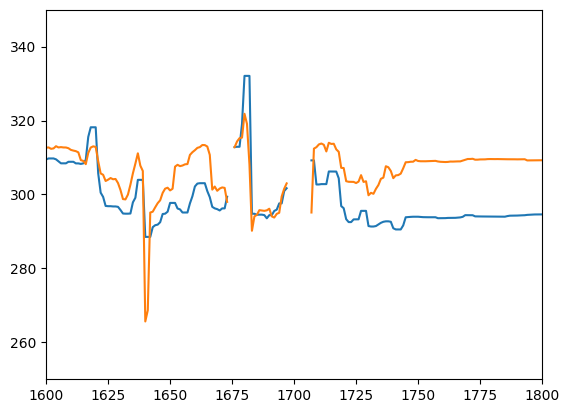

In [236]:
# plt.plot(p2d_nan[1, 0::2, 0])
# plt.plot(cam[1, 0::2, 0])

plt.plot(p2d_nan[1, 0::2, 1])
plt.plot(cam[1, 0::2, 1])  

# plt.plot(p2d_nan[0, 1::2, 0])
# plt.plot(cam[0, 1::2, 0])

# plt.plot(p2d_nan[0, 1::2, 1])
# plt.plot(cam[0, 1::2, 1])  

plt.ylim([250, 350])
plt.xlim([1600, 1800])


(1600.0, 1800.0)

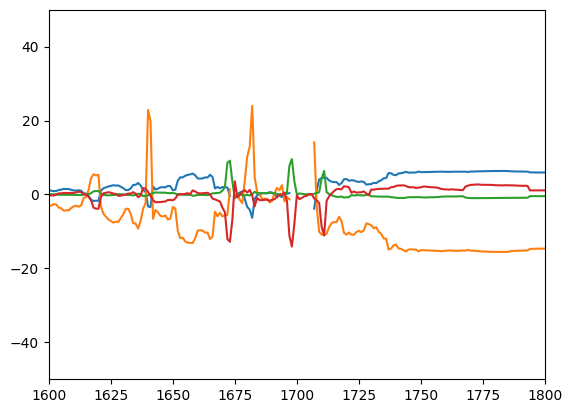

In [235]:
plt.plot(p2d_nan[1, 0::2, 0]-cam[1, 0::2, 0])

plt.plot(p2d_nan[1, 0::2, 1]-cam[1, 0::2, 1])  

plt.plot(p2d_nan[0, 1::2, 0]-cam[0, 1::2, 0])

plt.plot(p2d_nan[0, 1::2, 1]-cam[0, 1::2, 1])  

plt.ylim([-50, 50])
plt.xlim([1000, 2000])
plt.xlim([1600, 1800])


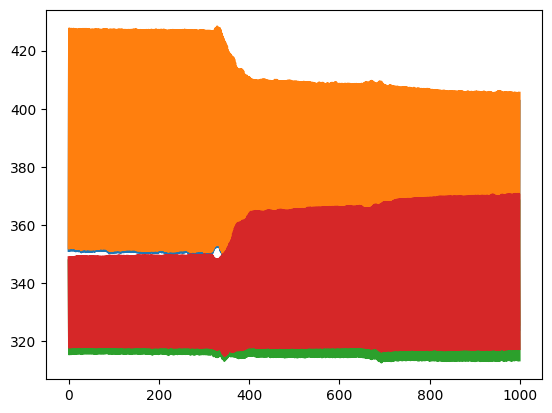

In [35]:
plt.plot(pts_array_2d[0, 0:1000, 0])
plt.plot(reprojected_2d[0, 0:1000, 0])

plt.plot(pts_array_2d[0, 0:1000, 1])
plt.plot(reprojected_2d[0, 0:1000, 1])            

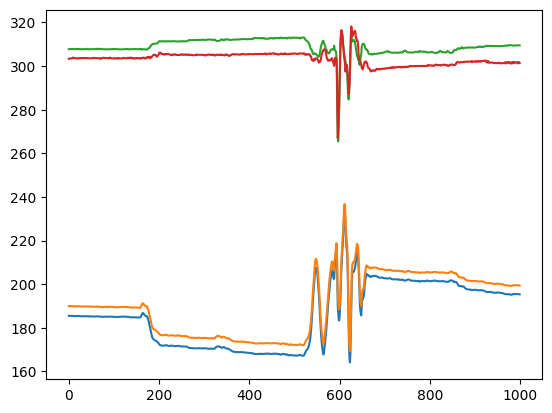

In [346]:
plt.plot(pts_array_2d[1, 0:1000, 0])
plt.plot(reprojected_2d[1, 0:1000, 0])

plt.plot(pts_array_2d[1, 0:1000, 1])
plt.plot(reprojected_2d[1, 0:1000, 1])      

Text(0, 0.5, 'Residuals (px)')

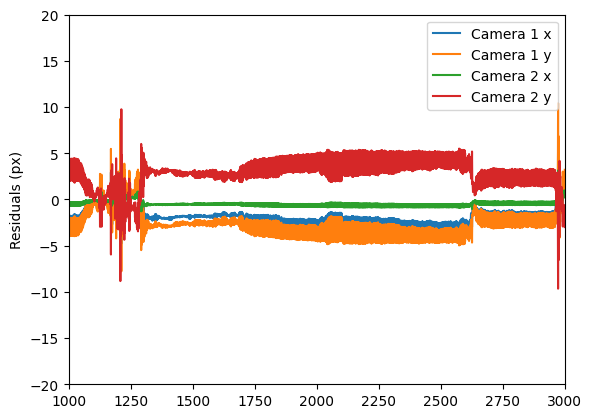

In [36]:
init = np.shape(reprojected_2d)[1]/2 +10
init = 1000
plt.plot(pts_array_2d[0, :, 0]-reprojected_2d[0, :, 0], label='Camera 1 x')
plt.plot(pts_array_2d[0, :, 1]-reprojected_2d[0, :, 1], label='Camera 1 y')
plt.plot((pts_array_2d[1, :, 0]-reprojected_2d[1, :, 0]), label='Camera 2 x')
plt.plot((pts_array_2d[1, :, 1]-reprojected_2d[1, :, 1]), label='Camera 2 y')
plt.legend()

plt.xlim([init, init+2000])
plt.ylim([-20, 20])
plt.ylabel('Residuals (px)')


In [ ]:
p3ds = cam_group.triangulate(pts_array_2d, progress=True)
reprojerr_flat = cam_group.reprojection_error(p3ds, pts_array_2d, mean=True)


In [ ]:
init = 2000

cam_group = set_ibl_cam_params()
p3ds = cam_group.triangulate(ppts_array_2d2ds, progress=True)
reprojerr_flat = cam_group.reprojection_error(p3ds, pts_array_2d, mean=True)
plt.plot(reprojerr_flat)
plt.show()
for i in range(4):
    cam_group = set_ibl_cam_params()
    error = cam_group.bundle_adjust_iter(p2ds, n_iters=10)
    if error <10:
        print(error)

        p3ds = cam_group.triangulate(p2ds, progress=True)
        reprojerr_flat = cam_group.reprojection_error(p3ds, p2ds, mean=True)
        plt.plot(reprojerr_flat)
        plt.ylim([0, 40])
        plt.show()

        plt.plot(p3ds[:, 0])
        plt.plot(p3ds[:, 1])
        plt.plot(p3ds[:, 2])
        plt.xlim([init, init+1000])
        
        plt.show()

## Ines' way

In [ ]:
session = sessions_to_process[7][1]

""" LOAD VARIABLES """
sl = SessionLoader(eid=session, one=one)
sl.load_pose(views=['left', 'right'], tracker='lightningPose')
sl.load_session_data(trials=True, wheel=True, motion_energy=True)

poses = sl.pose
likelihood_threshold = 0.95
bad_l_left = poses['leftCamera']['paw_l_likelihood']<likelihood_threshold
poses['leftCamera'].loc[poses['leftCamera']['paw_l_likelihood']<likelihood_threshold, 'paw_l_x'] = np.nan
poses['leftCamera'].loc[poses['leftCamera']['paw_l_likelihood']<likelihood_threshold, 'paw_l_y'] = np.nan
poses['leftCamera'].loc[poses['leftCamera']['paw_r_likelihood']<likelihood_threshold, 'paw_r_x'] = np.nan
poses['leftCamera'].loc[poses['leftCamera']['paw_r_likelihood']<likelihood_threshold, 'paw_r_y'] = np.nan

poses['rightCamera'].loc[poses['rightCamera']['paw_l_likelihood']<likelihood_threshold, 'paw_l_x'] = np.nan
poses['rightCamera'].loc[poses['rightCamera']['paw_l_likelihood']<likelihood_threshold, 'paw_l_y'] = np.nan
poses['rightCamera'].loc[poses['rightCamera']['paw_r_likelihood']<likelihood_threshold, 'paw_r_x'] = np.nan
poses['rightCamera'].loc[poses['rightCamera']['paw_r_likelihood']<likelihood_threshold, 'paw_r_y'] = np.nan

# Camera times
leftCam_time = np.array(poses['leftCamera']['times'])
rightCam_time = np.array(poses['rightCamera']['times'])

# Left paw Left camera
l_paw_x_leftCam = np.array(poses['leftCamera']['paw_r_x'])
l_paw_y_leftCam = np.array(poses['leftCamera']['paw_r_y'])
# Left paw Right camera
l_paw_x_rightCam = np.array(poses['rightCamera']['paw_l_x'])
l_paw_y_rightCam = np.array(poses['rightCamera']['paw_l_y'])

# Right paw Left camera
r_paw_x_leftCam = np.array(poses['leftCamera']['paw_l_x'])
r_paw_y_leftCam = np.array(poses['leftCamera']['paw_l_y'])
# Right paw Right camera
r_paw_x_rightCam = np.array(poses['rightCamera']['paw_r_x'])
r_paw_y_rightCam = np.array(poses['rightCamera']['paw_r_y'])

""" COMMON TIMESTAMPS AND RESAMPLING"""
# Use reference time, truncate and resample
onset = np.max([np.min(leftCam_time), np.min(rightCam_time)])
offset = np.min([np.max(leftCam_time), np.max(rightCam_time)])

common_fs = 60
# Set common sampling rate (high rather than low)
reference_time = np.arange(onset, offset, 1/common_fs)  # uniform timestamps

l_paw_x_leftCam = l_paw_x_leftCam[np.where((leftCam_time >= onset) & (leftCam_time < offset))]
l_paw_y_leftCam = l_paw_y_leftCam[np.where((leftCam_time >= onset) & (leftCam_time < offset))]
l_paw_x_rightCam = l_paw_x_rightCam[np.where((rightCam_time >= onset) & (rightCam_time < offset))]
l_paw_y_rightCam = l_paw_y_rightCam[np.where((rightCam_time >= onset) & (rightCam_time < offset))]

r_paw_x_leftCam = r_paw_x_leftCam[np.where((leftCam_time >= onset) & (leftCam_time < offset))]
r_paw_y_leftCam = r_paw_y_leftCam[np.where((leftCam_time >= onset) & (leftCam_time < offset))]
r_paw_x_rightCam = r_paw_x_rightCam[np.where((rightCam_time >= onset) & (rightCam_time < offset))]
r_paw_y_rightCam = r_paw_y_rightCam[np.where((rightCam_time >= onset) & (rightCam_time < offset))]

rightCam_time = rightCam_time[np.where((rightCam_time >= onset) & (rightCam_time < offset))]
leftCam_time = leftCam_time[np.where((leftCam_time >= onset) & (leftCam_time < offset))]

donwsampled_l_paw_x_leftCam, corrected_l_paw_x_leftCam_t = resample_common_time(reference_time, leftCam_time, l_paw_x_leftCam, kind='linear', fill_gaps=None)
donwsampled_l_paw_y_leftCam, corrected_l_paw_y_leftCam_t = resample_common_time(reference_time, leftCam_time, l_paw_y_leftCam, kind='linear', fill_gaps=None)

donwsampled_l_paw_x_rightCam, corrected_l_paw_x_rightCam_t = resample_common_time(reference_time, rightCam_time, l_paw_x_rightCam, kind='linear', fill_gaps=None)
donwsampled_l_paw_y_rightCam, corrected_l_paw_y_rightCam_t = resample_common_time(reference_time, rightCam_time, l_paw_y_rightCam, kind='linear', fill_gaps=None)

donwsampled_r_paw_x_leftCam, corrected_r_paw_x_leftCam_t = resample_common_time(reference_time, leftCam_time, r_paw_x_leftCam, kind='linear', fill_gaps=None)
donwsampled_r_paw_y_leftCam, corrected_r_paw_y_leftCam_t = resample_common_time(reference_time, leftCam_time, r_paw_y_leftCam, kind='linear', fill_gaps=None)

donwsampled_r_paw_x_rightCam, corrected_r_paw_x_rightCam_t = resample_common_time(reference_time, rightCam_time, r_paw_x_rightCam, kind='linear', fill_gaps=None)
donwsampled_r_paw_y_rightCam, corrected_r_paw_y_rightCam_t = resample_common_time(reference_time, rightCam_time, r_paw_y_rightCam, kind='linear', fill_gaps=None)
# Check integrity of data
# assert (corrected_l_paw_x_t == corrected_r_paw_x_t).all(), print('Assertion error')

/opt/anaconda3/envs/iblenv/lib/python3.10/site-packages/one/util.py:428: ALFWarning: Multiple revisions: "", "2023-04-20"
  warnings.warn(f'Multiple revisions: {rev_list}', alferr.ALFWarning)
/opt/anaconda3/envs/iblenv/lib/python3.10/site-packages/one/util.py:428: ALFWarning: Multiple revisions: "", "2023-04-20"
  warnings.warn(f'Multiple revisions: {rev_list}', alferr.ALFWarning)
(S3) /Users/ineslaranjeira/Downloads/FlatIron/churchlandlab_ucla/Subjects/UCLA033/2022-02-24/001/alf/_ibl_rightCamera.lightningPose.pqt: 100%|██████████| 334M/334M [01:26<00:00, 3.88MB/s] 


2025-08-28 10:41:57 INFO     one.py:1288 Loading trials data


/opt/anaconda3/envs/iblenv/lib/python3.10/site-packages/one/util.py:428: ALFWarning: Multiple revisions: "", "2025-03-03"
  warnings.warn(f'Multiple revisions: {rev_list}', alferr.ALFWarning)


2025-08-28 10:41:58 INFO     one.py:1288 Loading wheel data
2025-08-28 10:42:00 INFO     one.py:1288 Loading motion_energy data


/opt/anaconda3/envs/iblenv/lib/python3.10/site-packages/one/util.py:428: ALFWarning: Multiple revisions: "2023-04-20", "2025-05-29"
  warnings.warn(f'Multiple revisions: {rev_list}', alferr.ALFWarning)
/opt/anaconda3/envs/iblenv/lib/python3.10/site-packages/one/util.py:428: ALFWarning: Multiple revisions: "2023-04-20", "2025-05-31"
  warnings.warn(f'Multiple revisions: {rev_list}', alferr.ALFWarning)


2025-08-28 10:42:02 INFO     one.py:1288 Loading pupil data


/opt/anaconda3/envs/iblenv/lib/python3.10/site-packages/one/util.py:428: ALFWarning: Multiple revisions: "2025-06-18", "2023-04-20"
  warnings.warn(f'Multiple revisions: {rev_list}', alferr.ALFWarning)


2025-08-28 10:42:02 WARNING  one.py:1292 Could not load pupil data.


In [ ]:
p2ds = np.zeros((2, len(donwsampled_l_paw_x_rightCam)*2, 2)) * np.nan
p2ds[0, :, 0] = np.hstack([donwsampled_l_paw_x_rightCam, donwsampled_r_paw_x_rightCam])
p2ds[0, :, 1] = np.hstack([donwsampled_l_paw_y_rightCam, donwsampled_r_paw_y_rightCam])
p2ds[1, :, 0] = np.hstack([donwsampled_l_paw_x_leftCam, donwsampled_r_paw_x_leftCam])
p2ds[1, :, 1] = np.hstack([donwsampled_l_paw_y_leftCam, donwsampled_r_paw_y_leftCam])

In [ ]:
rightCam_nan = np.isnan(donwsampled_l_paw_x_rightCam)
leftCam_nan = np.isnan(donwsampled_l_paw_x_leftCam)

remove_nans = np.concatenate([np.where(rightCam_nan)[0], np.where(leftCam_nan)[0]])
remove_nans = np.unique(remove_nans)

l_paw_x_rightCam = np.delete(donwsampled_l_paw_x_rightCam, remove_nans)
l_paw_y_rightCam = np.delete(donwsampled_l_paw_y_rightCam, remove_nans)
r_paw_x_rightCam = np.delete(donwsampled_l_paw_x_leftCam, remove_nans)
r_paw_y_rightCam = np.delete(donwsampled_l_paw_y_leftCam, remove_nans)

In [ ]:

p2ds = np.zeros((2, len(l_paw_x_rightCam), 2)) * np.nan
p2ds[0, :, 0] = l_paw_x_rightCam
p2ds[0, :, 1] = l_paw_y_rightCam
p2ds[1, :, 0] = r_paw_x_rightCam
p2ds[1, :, 1] = r_paw_y_rightCam


In [ ]:
np.save('p2ds', p2ds)

# Loading saved data

In [ ]:
p2ds = np.load(functions_path +'p2ds.npy')

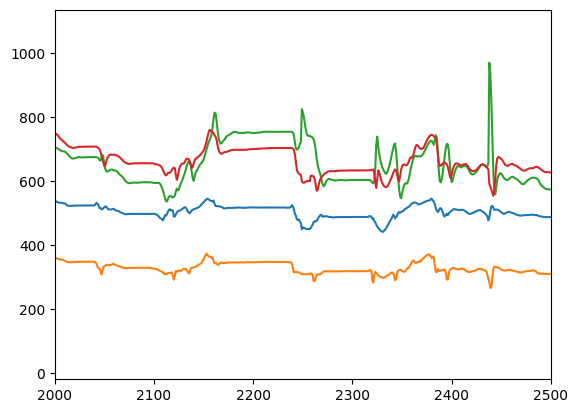

In [ ]:
plt.plot(p2ds[0, :, 0])
plt.plot(p2ds[0, :, 1])
plt.plot(p2ds[1, :, 0])
plt.plot(p2ds[1, :, 1])
plt.xlim([2000, 2500])
plt.show()

In [ ]:
def set_ibl_cam_params():
    FOCAL_LENGTH_MM = 16
    SENSOR_SIZE = 12.7
    IMG_HEIGHT = 512
    IMG_WIDTH = 640

    # rightCamera (treat this as origin)
    params_r = np.zeros(8)
    params_r[0:3] = np.array([0, 0, 0])  # rotation
    params_r[3:6] = np.array([0, 0, 0])  # translation
    params_r[6] = FOCAL_LENGTH_MM * IMG_WIDTH / SENSOR_SIZE  # in pixels
    # params_r[7:] are distortion params, init to zero
    size_r = (IMG_WIDTH, IMG_HEIGHT)
    cam_r = Camera(size=size_r)
    cam_r.set_params(params_r)
    # update principal point
    cam_r_mat = cam_r.get_camera_matrix()
    cam_r_mat[0, 2] = IMG_WIDTH
    cam_r_mat[1, 2] = IMG_HEIGHT
    cam_r.set_camera_matrix(cam_r_mat)

    # leftCamera
    params_l = np.zeros(8)
    params_l[0:3] = np.array([0, 2.0127, 0])  # rotation; around y axis only, about 120 deg (2.0127 rad) from Guido's CAD
    params_l[3:6] = np.array([-1.5664, 0, 2.4738])  # translation; cameras are 292.8 mm apart
    params_l[6] = FOCAL_LENGTH_MM * 2 * IMG_WIDTH / SENSOR_SIZE
    # params_l[7:] are distortion params, init to zero
    size_l = (2 * IMG_WIDTH, 2 * IMG_HEIGHT)
    cam_l = Camera(size=size_l)
    cam_l.set_params(params_l)
    # update principal point
    cam_l_mat = cam_l.get_camera_matrix()
    cam_l_mat[0, 2] = 2 * IMG_WIDTH
    cam_l_mat[1, 2] = 2 * IMG_HEIGHT
    cam_l.set_camera_matrix(cam_l_mat)

    cam_group = CameraGroup(cameras=[cam_r, cam_l])

    return cam_group


In [ ]:
    FOCAL_LENGTH_MM = 16
    SENSOR_SIZE = 12.7
    IMG_HEIGHT = 512
    IMG_WIDTH = 640

    # rightCamera (treat this as origin)
    params_r = np.zeros(8)
    params_r[0:3] = np.array([0, 0, 0])  # rotation
    params_r[3:6] = np.array([0, 0, 0])  # translation
    params_r[6] = FOCAL_LENGTH_MM * IMG_WIDTH / SENSOR_SIZE  # in pixels
    # params_r[7:] are distortion params, init to zero
    size_r = (IMG_WIDTH, IMG_HEIGHT)
    cam_r = Camera(size=size_r)
    cam_r.set_params(params_r)
    # update principal point
    cam_r_mat = cam_r.get_camera_matrix()
    cam_r_mat[0, 2] = IMG_WIDTH
    cam_r_mat[1, 2] = IMG_HEIGHT
    cam_r.set_camera_matrix(cam_r_mat)

    # leftCamera
    params_l = np.zeros(8)
    params_l[0:3] = np.array([0, 2.0127, 0])  # rotation; around y axis only, about 120 deg (2.0127 rad) from Guido's CAD
    params_l[3:6] = np.array([-1.5664, 0, 2.4738])  # translation; cameras are 292.8 mm apart
    params_l[6] = FOCAL_LENGTH_MM * 2 * IMG_WIDTH / SENSOR_SIZE
    # params_l[7:] are distortion params, init to zero
    size_l = (2 * IMG_WIDTH, 2 * IMG_HEIGHT)
    cam_l = Camera(size=size_l)
    cam_l.set_params(params_l)
    # update principal point
    cam_l_mat = cam_l.get_camera_matrix()
    cam_l_mat[0, 2] = 2 * IMG_WIDTH
    cam_l_mat[1, 2] = 2 * IMG_HEIGHT
    cam_l.set_camera_matrix(cam_l_mat)

    cam_group = CameraGroup(cameras=[cam_r, cam_l])

In [ ]:
cam_group = set_ibl_cam_params()

In [ ]:
cam_group = set_ibl_cam_params()
print(cam_group.get_dicts()[0]['distortions'])
print(cam_group.get_dicts()[1]['distortions'])

for i in range(4):
    cam_group = set_ibl_cam_params()
    error = cam_group.bundle_adjust_iter(p2ds, n_iters=2)
    print(error)
    print(cam_group.get_dicts()[0]['distortions'])
    print(cam_group.get_dicts()[1]['distortions'])

[0.0, 0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0, 0.0]
8.473334433378271
[0.187621674953114, 0.0, 0.0, 0.0, 0.0]
[-1.3082928263468336, 0.0, 0.0, 0.0, 0.0]
107.76139417020593
[3.7073697920282904, 0.0, 0.0, 0.0, 0.0]
[1.7181312533287645, 0.0, 0.0, 0.0, 0.0]
2.046766364286748
[-0.3146892888497368, 0.0, 0.0, 0.0, 0.0]
[0.794638999158065, 0.0, 0.0, 0.0, 0.0]
188.74741959039648
[4.646047774457398, 0.0, 0.0, 0.0, 0.0]
[2.548929455537457, 0.0, 0.0, 0.0, 0.0]


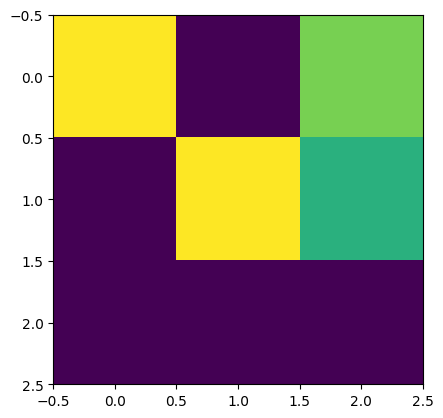

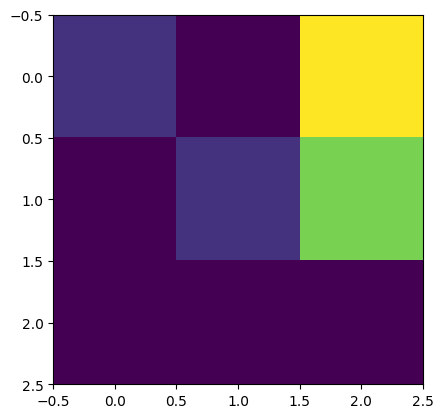

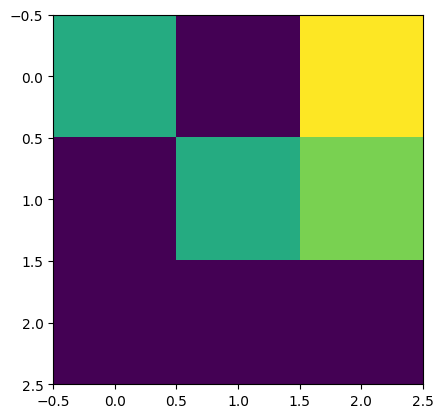

1.8888736588540405


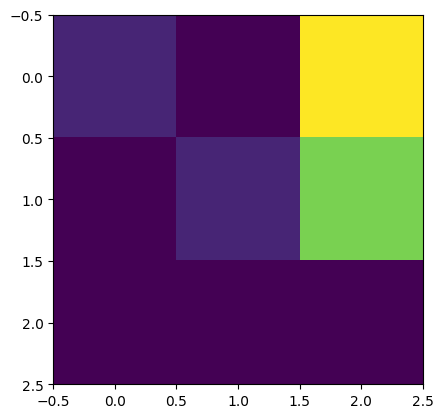

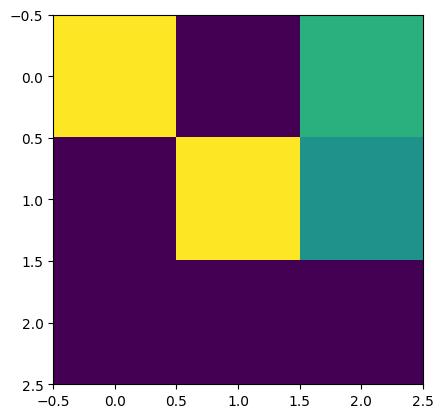

3.9415499400695557


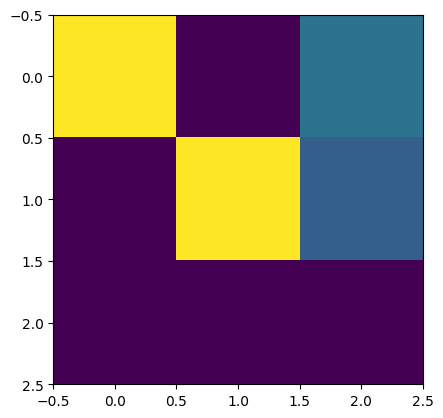

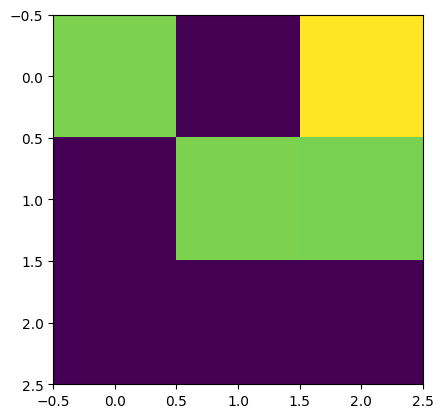

105.89071430440458


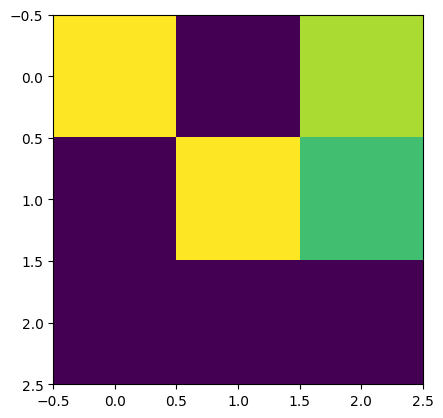

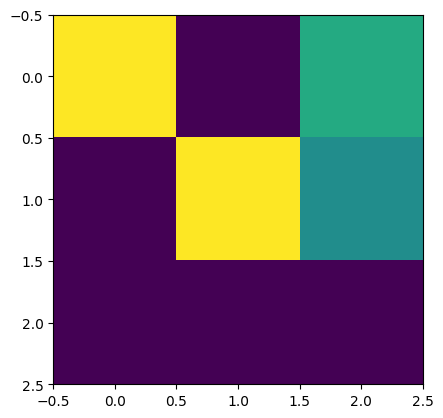

1.717465857048749


In [ ]:
cam_group = set_ibl_cam_params()
plt.imshow(cam_group.get_dicts()[0]['matrix'])
plt.show()
for i in range(4):
    cam_group = set_ibl_cam_params()
    error = cam_group.bundle_adjust_iter(p2ds)
    plt.imshow(cam_group.get_dicts()[0]['matrix'])
    plt.show()
    plt.imshow(cam_group.get_dicts()[1]['matrix'])
    plt.show()

    print(error)

100%|███████████████████████| 266765/266765 [02:34<00:00, 1727.97it/s]


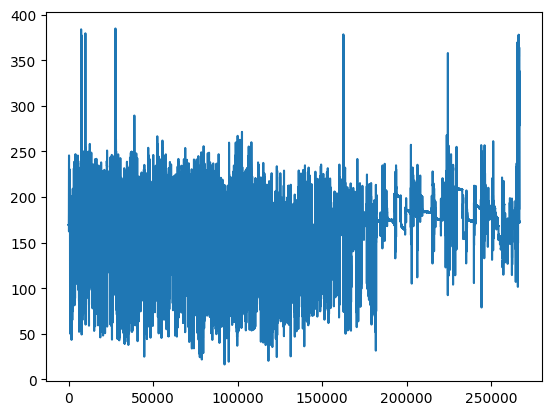

3.368225168087314


100%|███████████████████████| 266765/266765 [02:33<00:00, 1739.28it/s]


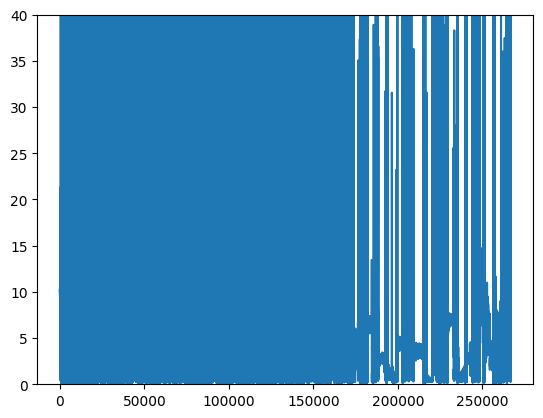

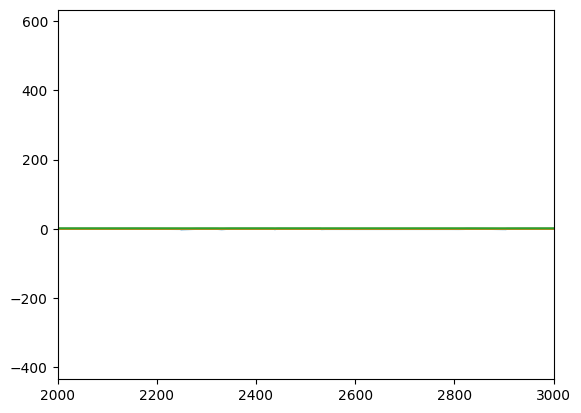

In [ ]:
init = 2000

cam_group = set_ibl_cam_params()
p3ds = cam_group.triangulate(p2ds, progress=True)
reprojerr_flat = cam_group.reprojection_error(p3ds, p2ds, mean=True)
plt.plot(reprojerr_flat)
plt.show()
for i in range(4):
    cam_group = set_ibl_cam_params()
    error = cam_group.bundle_adjust_iter(p2ds, n_iters=10)
    if error <10:
        print(error)

        p3ds = cam_group.triangulate(p2ds, progress=True)
        reprojerr_flat = cam_group.reprojection_error(p3ds, p2ds, mean=True)
        plt.plot(reprojerr_flat)
        plt.ylim([0, 40])
        plt.show()

        plt.plot(p3ds[:, 0])
        plt.plot(p3ds[:, 1])
        plt.plot(p3ds[:, 2])
        plt.xlim([init, init+1000])
        
        plt.show()

100%|███████████████████████| 291014/291014 [03:13<00:00, 1507.51it/s]


(2000.0, 3000.0)

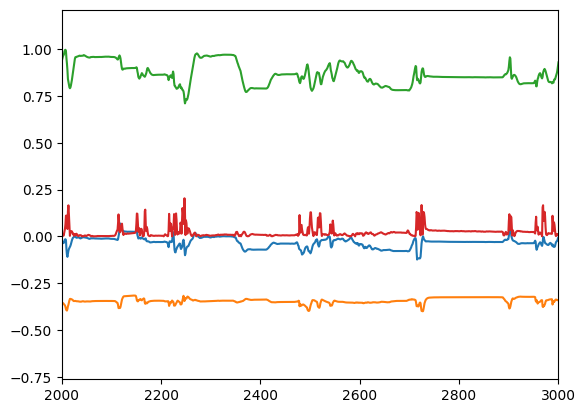

In [ ]:
init = 2000
p3ds = cam_group.triangulate(p2ds, progress=True)
reprojerr_flat = cam_group.reprojection_error(p3ds, p2ds, mean=True)
plt.plot(p3ds[:, 0])
plt.plot(p3ds[:, 1])
plt.plot(p3ds[:, 2])
plt.plot(reprojerr_flat/200)
plt.xlim([init, init+1000])

In [ ]:
reprojerr_flat

array([ 2.98031407,  2.92549734,  3.01159671, ..., 11.35884347,
       12.7569134 ,  9.2141098 ])

(0.0, 20.0)

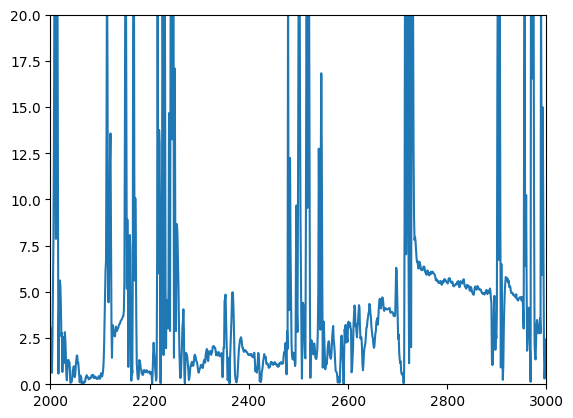

In [ ]:
init = 2000
reprojerr_flat = cam_group.reprojection_error(p3ds, p2ds, mean=True)
# plt.plot(p3ds[:, 0])
# plt.plot(p3ds[:, 1])
# plt.plot(p3ds[:, 2])
plt.plot(reprojerr_flat)
plt.xlim([init, init+1000])
plt.ylim([0, 20])

In [ ]:
alphas = [1, .4]
for i, n_iters in enumerate([1, 100]):
  
  p3ds = cam_group.triangulate(p2ds, progress=True)
  reprojerr_flat = cam_group.reprojection_error(p3ds, p2ds, mean=True)

  # p3ds = p3ds_flat.reshape(n_points, n_joints, 3)
  # reprojerr = reprojerr_flat.reshape(n_points, n_joints)
  # Camera.get_params(cam_l)

  init = 2000

#   plt.plot(p3ds[:, 0]+1.3, alpha=alphas[i])
#   plt.plot(p3ds[:, 1]+1, alpha=alphas[i])
  plt.plot(p3ds[:, 2], alpha=alphas[i])
  # plt.plot(reprojerr_flat/200)
  plt.xlim([init, init+1000])
plt.show()

# plt.plot(p2ds[0, :, 0])
# plt.plot(p2ds[0, :, 1])
# plt.plot(p2ds[1, :, 0])
# plt.plot(p2ds[1, :, 1])
# plt.xlim([init, init+1000])
# plt.show()

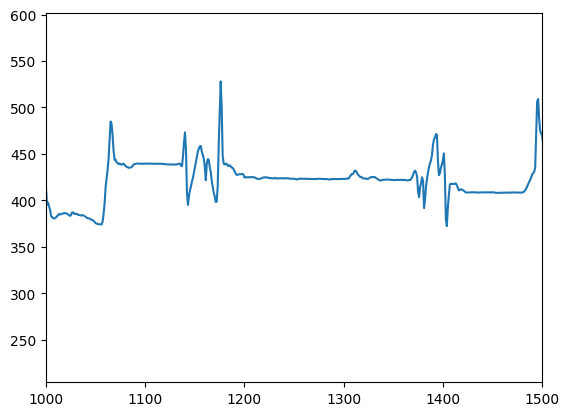

In [ ]:
init = 1000
plt.plot(p2ds[0, :, 0])
# plt.plot(p3ds[:, 1])
# plt.plot(p3ds[:, 2])
# plt.plot(reprojerr_flat/200)
plt.xlim([init, init+500])
# plt.ylim([-.5, .5])
plt.show()

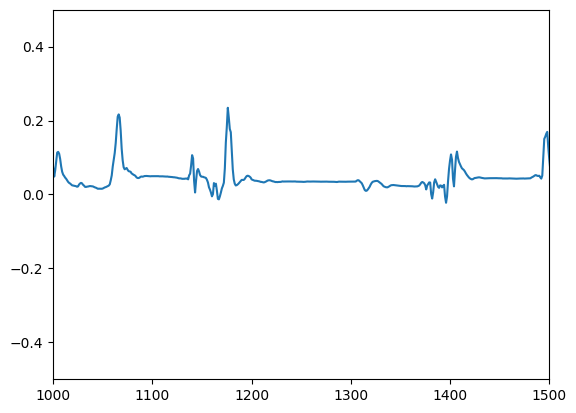

In [ ]:
init = 1000
plt.plot(p3ds[:, 0])
# plt.plot(p3ds[:, 1])
# plt.plot(p3ds[:, 2])
# plt.plot(reprojerr_flat/200)
plt.xlim([init, init+500])
plt.ylim([-.5, .5])
plt.show()

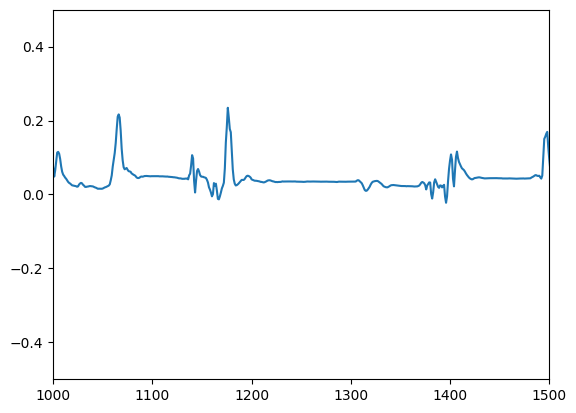

In [ ]:
init = 1000
plt.plot(p3ds[:, 0])
# plt.plot(p3ds[:, 1])
# plt.plot(p3ds[:, 2])
# plt.plot(reprojerr_flat/200)
plt.xlim([init, init+500])
plt.ylim([-.5, .5])
plt.show()